In [2]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch.autograd import Variable 
import torchvision
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
from torchvision import datasets
import argparse
import os
import matplotlib.pyplot as plt

In [3]:
##### 分别设置torch和numpy的种子
manualSeed = 36

np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)
# 给CPU或者GPU设定随机数的原因是为了让以后torch.rand产生的随机数都相同

# Check if we have a CUDA-capable device; if so, use it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Will train on {}'.format(device))

Will train on cuda


In [4]:
# Data
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(size=32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

root = '/home/jixianrui/Jupyter/Attention_spatial/data'  #给定cifar10数据的目录

trainset = torchvision.datasets.CIFAR10(root, train=True, download=False, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root, train=False, download=False, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print('==> Finish Preparing.')

==> Preparing data..
==> Finish Preparing.


## 缩减cifar10的大小

In [5]:
# 找到标签lab
lab_train = [trainset[x][1] for x in range(len(trainset))]
lab_test = [testset[y][1] for y in range(len(testset))]

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from torch.utils.data.dataset import Subset

def generate_train_indices(n_splits, train_size, lab):
    s = StratifiedShuffleSplit(n_splits=n_splits, train_size=train_size, test_size=None)
    return [i.tolist() for i, _ in s.split(lab, lab)]

train_indices = generate_train_indices(10, 10000, lab_train)
train_subset = Subset(trainset, train_indices[1])
print(Counter([train_subset[i][1] for i in range(len(train_subset))]))
print(len(train_subset))

Counter({8: 1000, 6: 1000, 7: 1000, 3: 1000, 4: 1000, 0: 1000, 5: 1000, 9: 1000, 2: 1000, 1: 1000})
10000


In [7]:
# def generate_test_indices(n_splits, test_size, lab):
#     s = StratifiedShuffleSplit(n_splits=n_splits, train_size=None, test_size=test_size)
#     return [i.tolist() for i, _ in s.split(lab, lab)]

# test_indices = generate_test_indices(10, 8000, lab_test)
# test_subset = Subset(testset, test_indices[1])
# print(Counter([test_subset[i][1] for i in range(len(test_subset))]))
# print(len(test_subset))

In [8]:
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

print(len(testloader.dataset))
print(len(trainloader.dataset))

10000
10000


## ResNet

In [9]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x), inplace=True)
        shortcut = self.shortcut(out)
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, lin=0, lout=5):
        out = x
        if lin < 1 and lout > -1:
            out = self.conv1(out)
            out = self.bn1(out)
            out = F.relu(out)
        if lin < 2 and lout > 0:
            out = self.layer1(out)
        if lin < 3 and lout > 1:
            out = self.layer2(out)
        if lin < 4 and lout > 2:
            out = self.layer3(out)
        if lin < 5 and lout > 3:
            out = self.layer4(out)
        if lout > 4:
            w = out
            out = F.avg_pool2d(out, 4)
            out = out.view(out.size(0), -1)
            out = self.linear(out)
        return out, w

def ResNet18():
#     print('finished resnet18')
    return ResNet(PreActBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])
  

if __name__ == '__main__':
    net = ResNet18().to(device)
    x = Variable(torch.randn(128,3,32,32)).to(device)
    out, w = net(x)
    print(out.size())
    print(w.size())

torch.Size([128, 10])
torch.Size([128, 512, 4, 4])


## 定义显示图片函数

In [10]:
def GetRandomNum():
    return np.random.randint(0, 9)

def GetImg(x, i):
    img = x[i, :]
    return img

def ShowImg(x):
    if x.size()[0] == 1:   
        new_img = torch.cat([x, x, x], dim=0)
        img = new_img.permute(1, 2, 0).cpu().detach().numpy()
        plt.imshow(img, cmap ='binary')
        plt.show()
    if x.size()[0] == 3:
        img = x.permute(1, 2, 0).cpu().detach().numpy()
        plt.imshow(img)   
        plt.show()

## 计算CAM

In [12]:
def ComputeCAM(features, softmax_weight, class_ids):
    class_ids = class_ids.long()
    m = []
    for idx in class_ids:
        wei = softmax_weight[idx, :].unsqueeze(0)
        m.append(wei)
    tensor_m = torch.cat(m, dim=0).unsqueeze(2).unsqueeze(3)
    cam = tensor_m * features
    cam = cam.sum(dim=1).unsqueeze(1)
    cam =  (cam - cam.min()) / (cam.max() - cam.min())
    weight = torch.nn.functional.interpolate(cam, scale_factor=8, mode='bilinear', align_corners=False)  # reshape its size as input
    return weight
    
def GetCam(model, inputs):
    out, features = model(inputs)
    _, idx = torch.max(out, 1)
    params = list(model.parameters())
    softmax_weight = params[-2].squeeze()
    weight = ComputeCAM(features, softmax_weight, idx)
    return weight

if __name__ == "__main__":
    x = torch.rand(10, 3, 32, 32).to(device)
    z = GetCam(net, x)
    print(z.size())

torch.Size([10, 1, 32, 32])


## 保存网络结构参数

In [13]:
import csv
import os

def save(epoch, tr_l, tr_a, te_l, te_a):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net,
        'epoch': epoch,
        'test_acc':te_a,
        'test_loss':te_l,
        'train_acc':tr_a,
        'train_loss':tr_l,
        'rng_state': torch.get_rng_state()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.t7' + '_' + str(epoch))

## 读取参数

In [14]:
if os.path.isdir('checkpoint'):
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7_79')
    net = checkpoint['net']
    net = net.to(device)
    
    start_epoch = checkpoint['epoch'] + 1
    te_a = checkpoint['test_acc']
    te_l = checkpoint['test_loss']
    tr_a = checkpoint['train_acc']
    tr_l = checkpoint['train_loss']
    rng_state = checkpoint['rng_state']
    torch.set_rng_state(rng_state)
    print('==> Finished')
    
else:
    print('==> Building model..')
    start_epoch = 0
    tr_a = []
    tr_l = []
    te_a = []
    te_l = []
    net = ResNet18()
    net = net.to(device)
    print('==> Finished')

==> Building model..
==> Finished


In [18]:
# @torchsnooper.snoop()
def train(epoch):
    net.train()
    train_loss = 0
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        output, _ = net(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        epoch_loss = train_loss / (batch_idx+1)

    return epoch_loss

In [19]:
def test(epoch, datasets):
    net.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(datasets):
        inputs, targets = inputs.to(device), targets.to(device)

        CAM = GetCam(net, inputs)
        output, _ = net(inputs)
        loss = criterion(output, targets)
        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cuda().sum()
        acc = 100. * correct / total
        epoch_loss = total_loss / (batch_idx+1)

    i = GetRandomNum()
    img0 = GetImg(inputs, i)
    img1 = GetImg(CAM, i)
    ShowImg(img1)
    ShowImg(img0)
    result = img1 * img0
    ShowImg(result)
    return epoch_loss, acc, correct

Epoch: 0
learning rate: 0.06
While train: 	CE loss: 1.8700


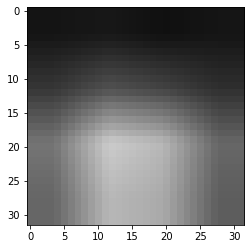

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


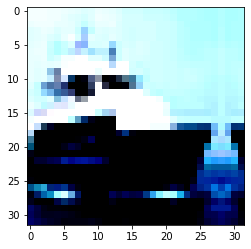

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


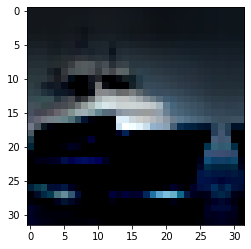

Train set: 	train loss: 2.0408 	Accuracy: 3273/10000 	(32.73%)


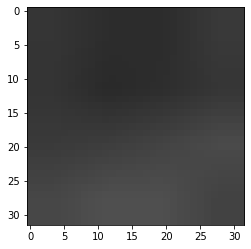

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


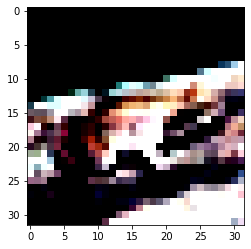

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


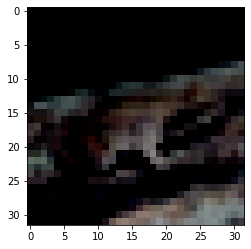

Test set: 	test loss: 2.0084 	Accuracy: 3385/10000 	(33.85%)

Epoch: 1
learning rate: 0.06
While train: 	CE loss: 1.5441


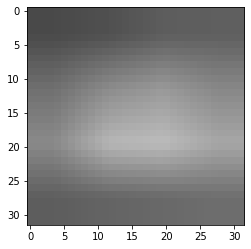

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


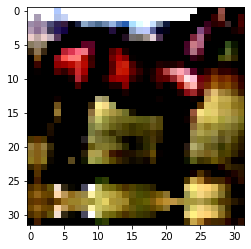

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


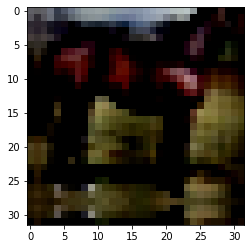

Train set: 	train loss: 1.6306 	Accuracy: 4043/10000 	(40.43%)


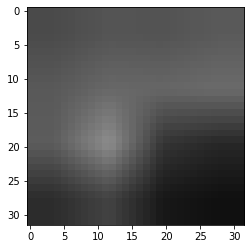

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


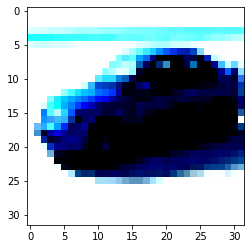

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


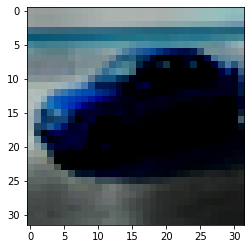

Test set: 	test loss: 1.6282 	Accuracy: 4032/10000 	(40.32%)

Epoch: 2
learning rate: 0.06
While train: 	CE loss: 1.3884


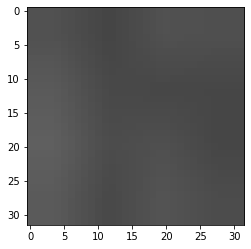

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


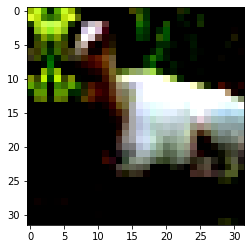

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


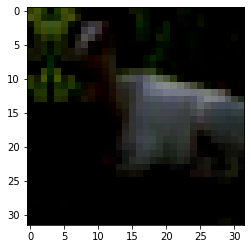

Train set: 	train loss: 1.3119 	Accuracy: 5228/10000 	(52.28%)


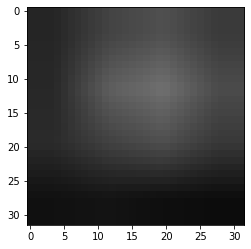

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


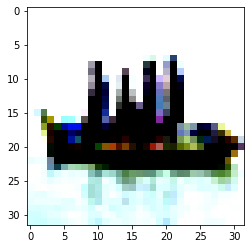

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


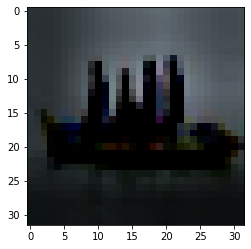

Test set: 	test loss: 1.2879 	Accuracy: 5400/10000 	(54.00%)

Epoch: 3
learning rate: 0.06
While train: 	CE loss: 1.2472


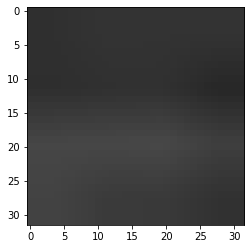

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


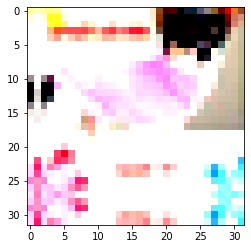

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


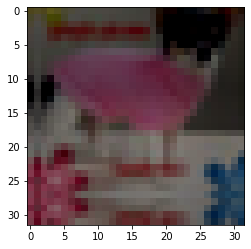

Train set: 	train loss: 1.2895 	Accuracy: 5476/10000 	(54.76%)


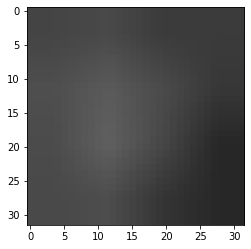

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


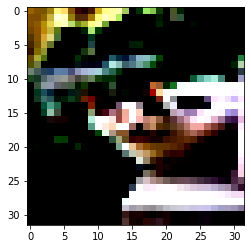

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


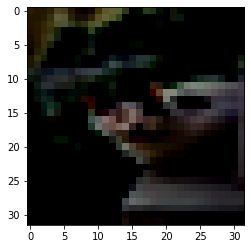

Test set: 	test loss: 1.2763 	Accuracy: 5483/10000 	(54.83%)

Epoch: 4
learning rate: 0.06
While train: 	CE loss: 1.1224


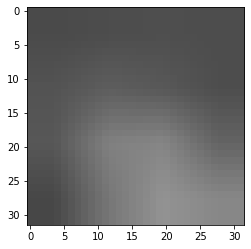

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


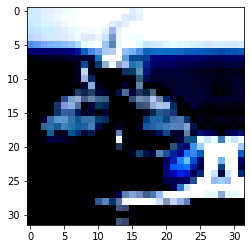

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


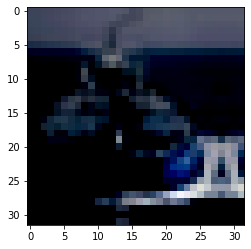

Train set: 	train loss: 1.4207 	Accuracy: 4988/10000 	(49.88%)


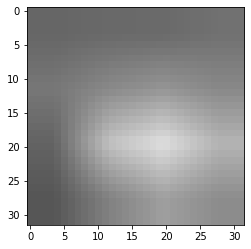

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


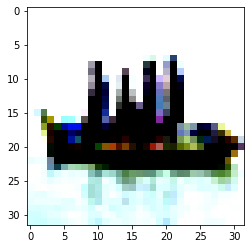

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


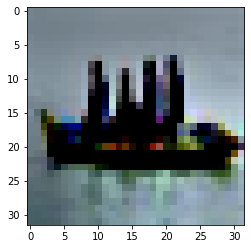

Test set: 	test loss: 1.4193 	Accuracy: 5076/10000 	(50.76%)

Epoch: 5
learning rate: 0.06
While train: 	CE loss: 1.0436


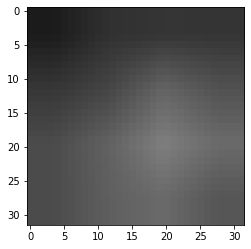

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


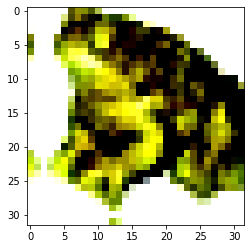

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


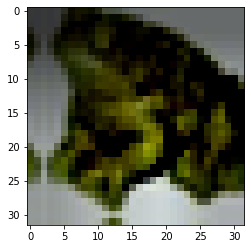

Train set: 	train loss: 1.0915 	Accuracy: 6121/10000 	(61.21%)


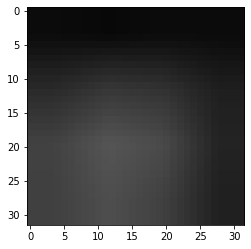

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


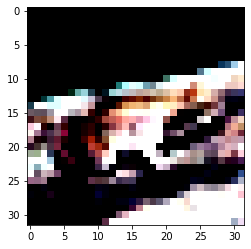

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


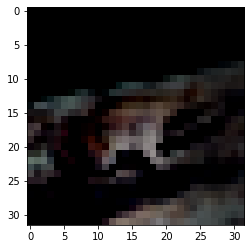

Test set: 	test loss: 1.1099 	Accuracy: 6082/10000 	(60.82%)

Epoch: 6
learning rate: 0.06
While train: 	CE loss: 0.9608


KeyboardInterrupt: 

In [20]:
n_epochs = 310

for epoch in range(start_epoch, n_epochs + 1):
    print('Epoch: %d' % epoch)

    criterion = nn.CrossEntropyLoss()

    adlr = 0.06
    if epoch >= 50:
        adlr /= 10
    if epoch >= 150:
        adlr = (300 - epoch) * 0.00004
    if epoch >= 300:
        adlr = 0
    print("learning rate:", adlr)
    
    optimizer = torch.optim.SGD(net.parameters(), lr=adlr, momentum=0.9, weight_decay=1e-3)
#     optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.)
     
    epoch_loss = train(epoch)
    print("While train: \tCE loss: {:.4f}".format(epoch_loss))
    train_loss, train_acc, train_correct = test(epoch, trainloader)
    train_size = len(trainloader.dataset)
    print('Train set: \ttrain loss: {:.4f} \tAccuracy: {}/{} \t({:.2f}%)'.format(train_loss, train_correct, train_size, train_acc))
    tr_l.append([epoch,epoch_loss])
    tr_a.append([epoch,train_acc])
    
    test_loss, test_acc, test_correct = test(epoch, testloader)
    test_size = len(testloader.dataset)
    print('Test set: \ttest loss: {:.4f} \tAccuracy: {}/{} \t({:.2f}%)\n'.format(test_loss, test_correct, test_size, test_acc))
    te_l.append([epoch,test_loss])
    te_a.append([epoch,test_acc])
    
    if epoch % 10 == 9:
        save(epoch, tr_l, tr_a, te_l, te_a)

<function matplotlib.pyplot.show(close=None, block=None)>

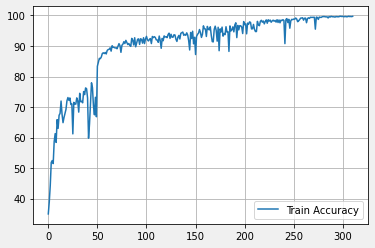

In [22]:
tr_a = np.array(tr_a)
plt.gcf().set_facecolor(np.ones(3)* 240 / 255)   # 生成画布的大小
plt.plot(tr_a[:,0], tr_a[:,1], label='Train Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

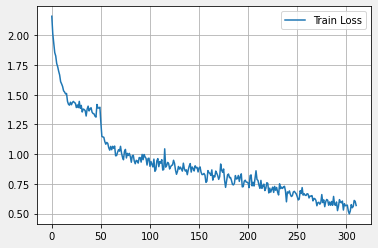

In [23]:
tr_l = np.array(tr_l)
plt.gcf().set_facecolor(np.ones(3)* 240 / 255)   # 生成画布的大小
plt.plot(tr_l[:,0], tr_l[:,1], label='Train Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

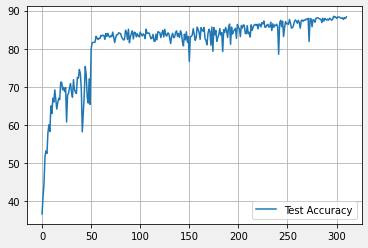

In [24]:
te_a = np.array(te_a)
plt.gcf().set_facecolor(np.ones(3)* 240 / 255)   # 生成画布的大小
plt.plot(te_a[:,0], te_a[:,1], label='Test Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

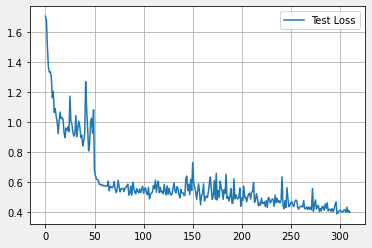

In [25]:
te_l = np.array(te_l)
plt.gcf().set_facecolor(np.ones(3)* 240 / 255)   # 生成画布的大小
plt.plot(te_l[:,0], te_l[:,1], label='Test Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

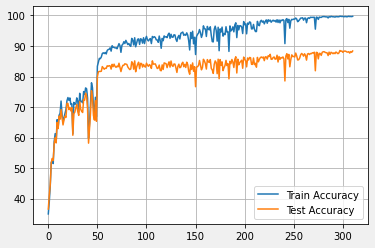

In [26]:
tr_a = np.array(tr_a)
te_a = np.array(te_a)
plt.gcf().set_facecolor(np.ones(3)* 240 / 255)   # 生成画布的大小
plt.plot(tr_a[:,0], tr_a[:,1], label='Train Accuracy')
plt.plot(te_a[:,0], te_a[:,1], label='Test Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

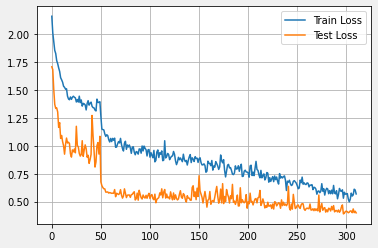

In [27]:
tr_l = np.array(tr_l)
te_l = np.array(te_l)
plt.gcf().set_facecolor(np.ones(3)* 240 / 255)   # 生成画布的大小
plt.plot(tr_l[:,0], tr_l[:,1], label='Train Loss')
plt.plot(te_l[:,0], te_l[:,1], label='Test Loss')
plt.legend(loc='upper right')
plt.grid()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

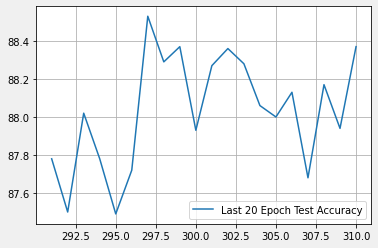

In [28]:
te_a = np.array(te_a)
plt.gcf().set_facecolor(np.ones(3)* 240 / 255)   # 生成画布的大小
plt.plot(te_a[-20:,0], te_a[-20:,1], label='Last 20 Epoch Test Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.show